In [112]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [114]:
# import the necessary packages
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os
from os.path import isfile, join

In [79]:
# Input Image
IMAGE = "bw_photo.jpg"

In [80]:
prototxt = "./model/colorization_deploy_v2.prototxt"
model = "./model/colorization_release_v2.caffemodel"
points = "./model/pts_in_hull.npy"
image =  "./input_images/"+IMAGE

In [81]:
net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(points)

In [82]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [83]:
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

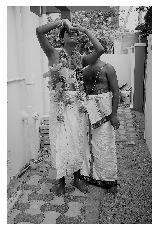

In [84]:
plt.imshow(image)
plt.axis('off');

In [85]:
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

In [86]:
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

In [87]:
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


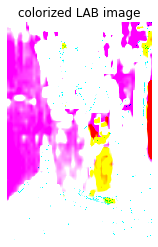

In [88]:
plt.imshow(colorized)
plt.axis('off');
plt.title('colorized LAB image');

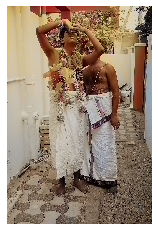

In [89]:
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")
plt.imshow(colorized)
plt.axis('off');

In [90]:
cv2.imwrite("./colorized_images/Color_"+IMAGE, cv2.cvtColor(colorized, cv2.COLOR_RGB2BGR))

True

# Video

In [123]:
VIDEO = "bw_video.mkv"

In [124]:
prototxt = "./model/colorization_deploy_v2.prototxt"
model = "./model/colorization_release_v2.caffemodel"
points = "./model/pts_in_hull.npy"
video =  "./input_videos/"+VIDEO
width = 500
vs = cv2.VideoCapture(video)

In [125]:
net = cv2.dnn.readNetFromCaffe(prototxt,model)
pts = np.load(points)
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [126]:
# loop over frames from the video stream
count = 0
success = True
while success:
	# grab the next frame and handle if we are reading from either
	# VideoCapture or VideoStream
	success, frame = vs.read()

	# if we are viewing a video and we did not grab a frame then we
	# have reached the end of the video
	if frame is None:
		break

	# resize the input frame, scale the pixel intensities to the
	# range [0, 1], and then convert the frame from the BGR to Lab
	# color space
	frame = imutils.resize(frame, 500)
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
	scaled = frame.astype("float32") / 255.0
	lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

	# resize the Lab frame to 224x224 (the dimensions the colorization
	# network accepts), split channels, extract the 'L' channel, and
	# then perform mean centering
	resized = cv2.resize(lab, (224, 224))
	L = cv2.split(resized)[0]
	L -= 50

	# pass the L channel through the network which will *predict* the
	# 'a' and 'b' channel values
	net.setInput(cv2.dnn.blobFromImage(L))
	ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

	# resize the predicted 'ab' volume to the same dimensions as our
	# input frame, then grab the 'L' channel from the *original* input
	# frame (not the resized one) and concatenate the original 'L'
	# channel with the predicted 'ab' channels
	ab = cv2.resize(ab, (frame.shape[1], frame.shape[0]))
	L = cv2.split(lab)[0]
	colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

	# convert the output frame from the Lab color space to RGB, clip
	# any values that fall outside the range [0, 1], and then convert
	# to an 8-bit unsigned integer ([0, 255] range)
	colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
	colorized = np.clip(colorized, 0, 1)
	colorized = (255 * colorized).astype("uint8")

	# show the original and final colorized frames
	cv2.imshow("Original", frame)
	cv2.imshow("Colorized", colorized)
    
	cv2.imwrite("./colorized_video_frames/frame%d.jpg" % count, colorized)
	count += 1
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

vs.release()

# close any open windows
cv2.destroyAllWindows()

In [117]:
def convert_frames_to_video(pathIn, pathOut, fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [128]:
pathIn= './colorized_video_frames/'
pathOut = './colorized_videos/video.avi'
fps = 30.0
convert_frames_to_video(pathIn, pathOut, fps)

./colorized_video_frames/frame0.jpg
./colorized_video_frames/frame1.jpg
./colorized_video_frames/frame2.jpg
./colorized_video_frames/frame3.jpg
./colorized_video_frames/frame4.jpg
./colorized_video_frames/frame5.jpg
./colorized_video_frames/frame6.jpg
./colorized_video_frames/frame7.jpg
./colorized_video_frames/frame8.jpg
./colorized_video_frames/frame9.jpg
./colorized_video_frames/frame10.jpg
./colorized_video_frames/frame11.jpg
./colorized_video_frames/frame12.jpg
./colorized_video_frames/frame13.jpg
./colorized_video_frames/frame14.jpg
./colorized_video_frames/frame15.jpg
./colorized_video_frames/frame16.jpg
./colorized_video_frames/frame17.jpg
./colorized_video_frames/frame18.jpg
./colorized_video_frames/frame19.jpg
./colorized_video_frames/frame20.jpg
./colorized_video_frames/frame21.jpg
./colorized_video_frames/frame22.jpg
./colorized_video_frames/frame23.jpg
./colorized_video_frames/frame24.jpg
./colorized_video_frames/frame25.jpg
./colorized_video_frames/frame26.jpg
./colorized

./colorized_video_frames/frame234.jpg
./colorized_video_frames/frame235.jpg
./colorized_video_frames/frame236.jpg
./colorized_video_frames/frame237.jpg
./colorized_video_frames/frame238.jpg
./colorized_video_frames/frame239.jpg
./colorized_video_frames/frame240.jpg
./colorized_video_frames/frame241.jpg
./colorized_video_frames/frame242.jpg
./colorized_video_frames/frame243.jpg
./colorized_video_frames/frame244.jpg
./colorized_video_frames/frame245.jpg
./colorized_video_frames/frame246.jpg
./colorized_video_frames/frame247.jpg
./colorized_video_frames/frame248.jpg
./colorized_video_frames/frame249.jpg
./colorized_video_frames/frame250.jpg
./colorized_video_frames/frame251.jpg
./colorized_video_frames/frame252.jpg
./colorized_video_frames/frame253.jpg
./colorized_video_frames/frame254.jpg
./colorized_video_frames/frame255.jpg
./colorized_video_frames/frame256.jpg
./colorized_video_frames/frame257.jpg
./colorized_video_frames/frame258.jpg
./colorized_video_frames/frame259.jpg
./colorized_

./colorized_video_frames/frame455.jpg
./colorized_video_frames/frame456.jpg
./colorized_video_frames/frame457.jpg
./colorized_video_frames/frame458.jpg
./colorized_video_frames/frame459.jpg
./colorized_video_frames/frame460.jpg
./colorized_video_frames/frame461.jpg
./colorized_video_frames/frame462.jpg
./colorized_video_frames/frame463.jpg
./colorized_video_frames/frame464.jpg
./colorized_video_frames/frame465.jpg
./colorized_video_frames/frame466.jpg
./colorized_video_frames/frame467.jpg
./colorized_video_frames/frame468.jpg
./colorized_video_frames/frame469.jpg
./colorized_video_frames/frame470.jpg
./colorized_video_frames/frame471.jpg
./colorized_video_frames/frame472.jpg
./colorized_video_frames/frame473.jpg
./colorized_video_frames/frame474.jpg
./colorized_video_frames/frame475.jpg
./colorized_video_frames/frame476.jpg
./colorized_video_frames/frame477.jpg
./colorized_video_frames/frame478.jpg
./colorized_video_frames/frame479.jpg
./colorized_video_frames/frame480.jpg
./colorized_

./colorized_video_frames/frame681.jpg
./colorized_video_frames/frame682.jpg
./colorized_video_frames/frame683.jpg
./colorized_video_frames/frame684.jpg
./colorized_video_frames/frame685.jpg
./colorized_video_frames/frame686.jpg
./colorized_video_frames/frame687.jpg
./colorized_video_frames/frame688.jpg
./colorized_video_frames/frame689.jpg
./colorized_video_frames/frame690.jpg
./colorized_video_frames/frame691.jpg
./colorized_video_frames/frame692.jpg
./colorized_video_frames/frame693.jpg
./colorized_video_frames/frame694.jpg
./colorized_video_frames/frame695.jpg
./colorized_video_frames/frame696.jpg
./colorized_video_frames/frame697.jpg
./colorized_video_frames/frame698.jpg
./colorized_video_frames/frame699.jpg
./colorized_video_frames/frame700.jpg
./colorized_video_frames/frame701.jpg
./colorized_video_frames/frame702.jpg
./colorized_video_frames/frame703.jpg
./colorized_video_frames/frame704.jpg
./colorized_video_frames/frame705.jpg
./colorized_video_frames/frame706.jpg
./colorized_

./colorized_video_frames/frame905.jpg
./colorized_video_frames/frame906.jpg
./colorized_video_frames/frame907.jpg
./colorized_video_frames/frame908.jpg
./colorized_video_frames/frame909.jpg
./colorized_video_frames/frame910.jpg
./colorized_video_frames/frame911.jpg
./colorized_video_frames/frame912.jpg
./colorized_video_frames/frame913.jpg
./colorized_video_frames/frame914.jpg
./colorized_video_frames/frame915.jpg
./colorized_video_frames/frame916.jpg
./colorized_video_frames/frame917.jpg
./colorized_video_frames/frame918.jpg
./colorized_video_frames/frame919.jpg
./colorized_video_frames/frame920.jpg
./colorized_video_frames/frame921.jpg
./colorized_video_frames/frame922.jpg
./colorized_video_frames/frame923.jpg
./colorized_video_frames/frame924.jpg
./colorized_video_frames/frame925.jpg
./colorized_video_frames/frame926.jpg
./colorized_video_frames/frame927.jpg
./colorized_video_frames/frame928.jpg
./colorized_video_frames/frame929.jpg
./colorized_video_frames/frame930.jpg
./colorized_

./colorized_video_frames/frame1120.jpg
./colorized_video_frames/frame1121.jpg
./colorized_video_frames/frame1122.jpg
./colorized_video_frames/frame1123.jpg
./colorized_video_frames/frame1124.jpg
./colorized_video_frames/frame1125.jpg
./colorized_video_frames/frame1126.jpg
./colorized_video_frames/frame1127.jpg
./colorized_video_frames/frame1128.jpg
./colorized_video_frames/frame1129.jpg
./colorized_video_frames/frame1130.jpg
./colorized_video_frames/frame1131.jpg
./colorized_video_frames/frame1132.jpg
./colorized_video_frames/frame1133.jpg
./colorized_video_frames/frame1134.jpg
./colorized_video_frames/frame1135.jpg
./colorized_video_frames/frame1136.jpg
./colorized_video_frames/frame1137.jpg
./colorized_video_frames/frame1138.jpg
./colorized_video_frames/frame1139.jpg
./colorized_video_frames/frame1140.jpg
./colorized_video_frames/frame1141.jpg
./colorized_video_frames/frame1142.jpg
./colorized_video_frames/frame1143.jpg
./colorized_video_frames/frame1144.jpg
./colorized_video_frames/

./colorized_video_frames/frame1336.jpg
./colorized_video_frames/frame1337.jpg
./colorized_video_frames/frame1338.jpg
./colorized_video_frames/frame1339.jpg
./colorized_video_frames/frame1340.jpg
./colorized_video_frames/frame1341.jpg
./colorized_video_frames/frame1342.jpg
./colorized_video_frames/frame1343.jpg
./colorized_video_frames/frame1344.jpg
./colorized_video_frames/frame1345.jpg
./colorized_video_frames/frame1346.jpg
./colorized_video_frames/frame1347.jpg
./colorized_video_frames/frame1348.jpg
./colorized_video_frames/frame1349.jpg
./colorized_video_frames/frame1350.jpg
./colorized_video_frames/frame1351.jpg
./colorized_video_frames/frame1352.jpg
./colorized_video_frames/frame1353.jpg
./colorized_video_frames/frame1354.jpg
./colorized_video_frames/frame1355.jpg
./colorized_video_frames/frame1356.jpg
./colorized_video_frames/frame1357.jpg
./colorized_video_frames/frame1358.jpg
./colorized_video_frames/frame1359.jpg
./colorized_video_frames/frame1360.jpg
./colorized_video_frames/

./colorized_video_frames/frame1566.jpg
./colorized_video_frames/frame1567.jpg
./colorized_video_frames/frame1568.jpg
./colorized_video_frames/frame1569.jpg
./colorized_video_frames/frame1570.jpg
./colorized_video_frames/frame1571.jpg
./colorized_video_frames/frame1572.jpg
./colorized_video_frames/frame1573.jpg
./colorized_video_frames/frame1574.jpg
./colorized_video_frames/frame1575.jpg
./colorized_video_frames/frame1576.jpg
./colorized_video_frames/frame1577.jpg
./colorized_video_frames/frame1578.jpg
./colorized_video_frames/frame1579.jpg
./colorized_video_frames/frame1580.jpg
./colorized_video_frames/frame1581.jpg
./colorized_video_frames/frame1582.jpg
./colorized_video_frames/frame1583.jpg
./colorized_video_frames/frame1584.jpg
./colorized_video_frames/frame1585.jpg
./colorized_video_frames/frame1586.jpg
./colorized_video_frames/frame1587.jpg
./colorized_video_frames/frame1588.jpg
./colorized_video_frames/frame1589.jpg
./colorized_video_frames/frame1590.jpg
./colorized_video_frames/

./colorized_video_frames/frame1787.jpg
./colorized_video_frames/frame1788.jpg
./colorized_video_frames/frame1789.jpg
./colorized_video_frames/frame1790.jpg
./colorized_video_frames/frame1791.jpg
./colorized_video_frames/frame1792.jpg
./colorized_video_frames/frame1793.jpg
./colorized_video_frames/frame1794.jpg
./colorized_video_frames/frame1795.jpg
./colorized_video_frames/frame1796.jpg
./colorized_video_frames/frame1797.jpg
./colorized_video_frames/frame1798.jpg
./colorized_video_frames/frame1799.jpg
./colorized_video_frames/frame1800.jpg
./colorized_video_frames/frame1801.jpg
./colorized_video_frames/frame1802.jpg
./colorized_video_frames/frame1803.jpg
./colorized_video_frames/frame1804.jpg
./colorized_video_frames/frame1805.jpg
./colorized_video_frames/frame1806.jpg
./colorized_video_frames/frame1807.jpg
./colorized_video_frames/frame1808.jpg
./colorized_video_frames/frame1809.jpg
./colorized_video_frames/frame1810.jpg
./colorized_video_frames/frame1811.jpg
./colorized_video_frames/

./colorized_video_frames/frame2004.jpg
./colorized_video_frames/frame2005.jpg
./colorized_video_frames/frame2006.jpg
./colorized_video_frames/frame2007.jpg
./colorized_video_frames/frame2008.jpg
./colorized_video_frames/frame2009.jpg
./colorized_video_frames/frame2010.jpg
./colorized_video_frames/frame2011.jpg
./colorized_video_frames/frame2012.jpg
./colorized_video_frames/frame2013.jpg
./colorized_video_frames/frame2014.jpg
./colorized_video_frames/frame2015.jpg
./colorized_video_frames/frame2016.jpg
./colorized_video_frames/frame2017.jpg
./colorized_video_frames/frame2018.jpg
./colorized_video_frames/frame2019.jpg
./colorized_video_frames/frame2020.jpg
./colorized_video_frames/frame2021.jpg
./colorized_video_frames/frame2022.jpg
./colorized_video_frames/frame2023.jpg
./colorized_video_frames/frame2024.jpg
./colorized_video_frames/frame2025.jpg
./colorized_video_frames/frame2026.jpg
./colorized_video_frames/frame2027.jpg
./colorized_video_frames/frame2028.jpg
./colorized_video_frames/

./colorized_video_frames/frame2216.jpg
./colorized_video_frames/frame2217.jpg
./colorized_video_frames/frame2218.jpg
./colorized_video_frames/frame2219.jpg
./colorized_video_frames/frame2220.jpg
./colorized_video_frames/frame2221.jpg
./colorized_video_frames/frame2222.jpg
./colorized_video_frames/frame2223.jpg
./colorized_video_frames/frame2224.jpg
./colorized_video_frames/frame2225.jpg
./colorized_video_frames/frame2226.jpg
./colorized_video_frames/frame2227.jpg
./colorized_video_frames/frame2228.jpg
./colorized_video_frames/frame2229.jpg
./colorized_video_frames/frame2230.jpg
./colorized_video_frames/frame2231.jpg
./colorized_video_frames/frame2232.jpg
./colorized_video_frames/frame2233.jpg
./colorized_video_frames/frame2234.jpg
./colorized_video_frames/frame2235.jpg
./colorized_video_frames/frame2236.jpg
./colorized_video_frames/frame2237.jpg
./colorized_video_frames/frame2238.jpg
./colorized_video_frames/frame2239.jpg
./colorized_video_frames/frame2240.jpg
./colorized_video_frames/

./colorized_video_frames/frame2444.jpg
./colorized_video_frames/frame2445.jpg
./colorized_video_frames/frame2446.jpg
./colorized_video_frames/frame2447.jpg
./colorized_video_frames/frame2448.jpg
./colorized_video_frames/frame2449.jpg
./colorized_video_frames/frame2450.jpg
./colorized_video_frames/frame2451.jpg
./colorized_video_frames/frame2452.jpg
./colorized_video_frames/frame2453.jpg
./colorized_video_frames/frame2454.jpg
./colorized_video_frames/frame2455.jpg
./colorized_video_frames/frame2456.jpg
./colorized_video_frames/frame2457.jpg
./colorized_video_frames/frame2458.jpg
./colorized_video_frames/frame2459.jpg
./colorized_video_frames/frame2460.jpg
./colorized_video_frames/frame2461.jpg
./colorized_video_frames/frame2462.jpg
./colorized_video_frames/frame2463.jpg
./colorized_video_frames/frame2464.jpg
./colorized_video_frames/frame2465.jpg
./colorized_video_frames/frame2466.jpg
./colorized_video_frames/frame2467.jpg
./colorized_video_frames/frame2468.jpg
./colorized_video_frames/

./colorized_video_frames/frame2658.jpg
./colorized_video_frames/frame2659.jpg
./colorized_video_frames/frame2660.jpg
./colorized_video_frames/frame2661.jpg
./colorized_video_frames/frame2662.jpg
./colorized_video_frames/frame2663.jpg
./colorized_video_frames/frame2664.jpg
./colorized_video_frames/frame2665.jpg
./colorized_video_frames/frame2666.jpg
./colorized_video_frames/frame2667.jpg
./colorized_video_frames/frame2668.jpg
./colorized_video_frames/frame2669.jpg
./colorized_video_frames/frame2670.jpg
./colorized_video_frames/frame2671.jpg
./colorized_video_frames/frame2672.jpg
./colorized_video_frames/frame2673.jpg
./colorized_video_frames/frame2674.jpg
./colorized_video_frames/frame2675.jpg
./colorized_video_frames/frame2676.jpg
./colorized_video_frames/frame2677.jpg
./colorized_video_frames/frame2678.jpg
./colorized_video_frames/frame2679.jpg
./colorized_video_frames/frame2680.jpg
./colorized_video_frames/frame2681.jpg
./colorized_video_frames/frame2682.jpg
./colorized_video_frames/

./colorized_video_frames/frame2879.jpg
./colorized_video_frames/frame2880.jpg
./colorized_video_frames/frame2881.jpg
./colorized_video_frames/frame2882.jpg
./colorized_video_frames/frame2883.jpg
./colorized_video_frames/frame2884.jpg
./colorized_video_frames/frame2885.jpg
./colorized_video_frames/frame2886.jpg
./colorized_video_frames/frame2887.jpg
./colorized_video_frames/frame2888.jpg
./colorized_video_frames/frame2889.jpg
./colorized_video_frames/frame2890.jpg
./colorized_video_frames/frame2891.jpg
./colorized_video_frames/frame2892.jpg
./colorized_video_frames/frame2893.jpg
./colorized_video_frames/frame2894.jpg
./colorized_video_frames/frame2895.jpg
./colorized_video_frames/frame2896.jpg
./colorized_video_frames/frame2897.jpg
./colorized_video_frames/frame2898.jpg
./colorized_video_frames/frame2899.jpg
./colorized_video_frames/frame2900.jpg
./colorized_video_frames/frame2901.jpg
./colorized_video_frames/frame2902.jpg
./colorized_video_frames/frame2903.jpg
./colorized_video_frames/

./colorized_video_frames/frame3109.jpg
./colorized_video_frames/frame3110.jpg
./colorized_video_frames/frame3111.jpg
./colorized_video_frames/frame3112.jpg
./colorized_video_frames/frame3113.jpg
./colorized_video_frames/frame3114.jpg
./colorized_video_frames/frame3115.jpg
./colorized_video_frames/frame3116.jpg
./colorized_video_frames/frame3117.jpg
./colorized_video_frames/frame3118.jpg
./colorized_video_frames/frame3119.jpg
./colorized_video_frames/frame3120.jpg
./colorized_video_frames/frame3121.jpg
./colorized_video_frames/frame3122.jpg
./colorized_video_frames/frame3123.jpg
./colorized_video_frames/frame3124.jpg
./colorized_video_frames/frame3125.jpg
./colorized_video_frames/frame3126.jpg
./colorized_video_frames/frame3127.jpg
./colorized_video_frames/frame3128.jpg
./colorized_video_frames/frame3129.jpg
./colorized_video_frames/frame3130.jpg
./colorized_video_frames/frame3131.jpg
./colorized_video_frames/frame3132.jpg
./colorized_video_frames/frame3133.jpg
./colorized_video_frames/

./colorized_video_frames/frame3324.jpg
./colorized_video_frames/frame3325.jpg
./colorized_video_frames/frame3326.jpg
./colorized_video_frames/frame3327.jpg
./colorized_video_frames/frame3328.jpg
./colorized_video_frames/frame3329.jpg
./colorized_video_frames/frame3330.jpg
./colorized_video_frames/frame3331.jpg
./colorized_video_frames/frame3332.jpg
./colorized_video_frames/frame3333.jpg
./colorized_video_frames/frame3334.jpg
./colorized_video_frames/frame3335.jpg
./colorized_video_frames/frame3336.jpg
./colorized_video_frames/frame3337.jpg
./colorized_video_frames/frame3338.jpg
./colorized_video_frames/frame3339.jpg
./colorized_video_frames/frame3340.jpg
./colorized_video_frames/frame3341.jpg
./colorized_video_frames/frame3342.jpg
./colorized_video_frames/frame3343.jpg
./colorized_video_frames/frame3344.jpg
./colorized_video_frames/frame3345.jpg
./colorized_video_frames/frame3346.jpg
./colorized_video_frames/frame3347.jpg
./colorized_video_frames/frame3348.jpg
./colorized_video_frames/

./colorized_video_frames/frame3545.jpg
./colorized_video_frames/frame3546.jpg
./colorized_video_frames/frame3547.jpg
./colorized_video_frames/frame3548.jpg
./colorized_video_frames/frame3549.jpg
./colorized_video_frames/frame3550.jpg
./colorized_video_frames/frame3551.jpg
./colorized_video_frames/frame3552.jpg
./colorized_video_frames/frame3553.jpg
./colorized_video_frames/frame3554.jpg
./colorized_video_frames/frame3555.jpg
./colorized_video_frames/frame3556.jpg
./colorized_video_frames/frame3557.jpg
./colorized_video_frames/frame3558.jpg
./colorized_video_frames/frame3559.jpg
./colorized_video_frames/frame3560.jpg
./colorized_video_frames/frame3561.jpg
./colorized_video_frames/frame3562.jpg
./colorized_video_frames/frame3563.jpg
./colorized_video_frames/frame3564.jpg
./colorized_video_frames/frame3565.jpg
./colorized_video_frames/frame3566.jpg
./colorized_video_frames/frame3567.jpg
./colorized_video_frames/frame3568.jpg
./colorized_video_frames/frame3569.jpg
./colorized_video_frames/

./colorized_video_frames/frame3761.jpg
./colorized_video_frames/frame3762.jpg
./colorized_video_frames/frame3763.jpg
./colorized_video_frames/frame3764.jpg
./colorized_video_frames/frame3765.jpg
./colorized_video_frames/frame3766.jpg
./colorized_video_frames/frame3767.jpg
./colorized_video_frames/frame3768.jpg
./colorized_video_frames/frame3769.jpg
./colorized_video_frames/frame3770.jpg
./colorized_video_frames/frame3771.jpg
./colorized_video_frames/frame3772.jpg
./colorized_video_frames/frame3773.jpg
./colorized_video_frames/frame3774.jpg
./colorized_video_frames/frame3775.jpg
./colorized_video_frames/frame3776.jpg
./colorized_video_frames/frame3777.jpg
./colorized_video_frames/frame3778.jpg
./colorized_video_frames/frame3779.jpg
./colorized_video_frames/frame3780.jpg
./colorized_video_frames/frame3781.jpg
./colorized_video_frames/frame3782.jpg
./colorized_video_frames/frame3783.jpg
./colorized_video_frames/frame3784.jpg
./colorized_video_frames/frame3785.jpg
./colorized_video_frames/

./colorized_video_frames/frame3972.jpg
./colorized_video_frames/frame3973.jpg
./colorized_video_frames/frame3974.jpg
./colorized_video_frames/frame3975.jpg
./colorized_video_frames/frame3976.jpg
./colorized_video_frames/frame3977.jpg
./colorized_video_frames/frame3978.jpg
./colorized_video_frames/frame3979.jpg
./colorized_video_frames/frame3980.jpg
./colorized_video_frames/frame3981.jpg
./colorized_video_frames/frame3982.jpg
./colorized_video_frames/frame3983.jpg
./colorized_video_frames/frame3984.jpg
./colorized_video_frames/frame3985.jpg
./colorized_video_frames/frame3986.jpg
./colorized_video_frames/frame3987.jpg
./colorized_video_frames/frame3988.jpg
./colorized_video_frames/frame3989.jpg
./colorized_video_frames/frame3990.jpg
./colorized_video_frames/frame3991.jpg
./colorized_video_frames/frame3992.jpg
./colorized_video_frames/frame3993.jpg
./colorized_video_frames/frame3994.jpg
./colorized_video_frames/frame3995.jpg
./colorized_video_frames/frame3996.jpg
./colorized_video_frames/

./colorized_video_frames/frame4196.jpg
./colorized_video_frames/frame4197.jpg
./colorized_video_frames/frame4198.jpg
./colorized_video_frames/frame4199.jpg
./colorized_video_frames/frame4200.jpg
./colorized_video_frames/frame4201.jpg
./colorized_video_frames/frame4202.jpg
./colorized_video_frames/frame4203.jpg
./colorized_video_frames/frame4204.jpg
./colorized_video_frames/frame4205.jpg
./colorized_video_frames/frame4206.jpg
./colorized_video_frames/frame4207.jpg
./colorized_video_frames/frame4208.jpg
./colorized_video_frames/frame4209.jpg
./colorized_video_frames/frame4210.jpg
./colorized_video_frames/frame4211.jpg
./colorized_video_frames/frame4212.jpg
./colorized_video_frames/frame4213.jpg
./colorized_video_frames/frame4214.jpg
./colorized_video_frames/frame4215.jpg
./colorized_video_frames/frame4216.jpg
./colorized_video_frames/frame4217.jpg
./colorized_video_frames/frame4218.jpg
./colorized_video_frames/frame4219.jpg
./colorized_video_frames/frame4220.jpg
./colorized_video_frames/

./colorized_video_frames/frame4423.jpg
./colorized_video_frames/frame4424.jpg
./colorized_video_frames/frame4425.jpg
./colorized_video_frames/frame4426.jpg
./colorized_video_frames/frame4427.jpg
./colorized_video_frames/frame4428.jpg
./colorized_video_frames/frame4429.jpg
./colorized_video_frames/frame4430.jpg
./colorized_video_frames/frame4431.jpg
./colorized_video_frames/frame4432.jpg
./colorized_video_frames/frame4433.jpg
./colorized_video_frames/frame4434.jpg
./colorized_video_frames/frame4435.jpg
./colorized_video_frames/frame4436.jpg
./colorized_video_frames/frame4437.jpg
./colorized_video_frames/frame4438.jpg
./colorized_video_frames/frame4439.jpg
./colorized_video_frames/frame4440.jpg
./colorized_video_frames/frame4441.jpg
./colorized_video_frames/frame4442.jpg
./colorized_video_frames/frame4443.jpg
./colorized_video_frames/frame4444.jpg
./colorized_video_frames/frame4445.jpg
./colorized_video_frames/frame4446.jpg
./colorized_video_frames/frame4447.jpg
./colorized_video_frames/

./colorized_video_frames/frame4638.jpg
./colorized_video_frames/frame4639.jpg
./colorized_video_frames/frame4640.jpg
./colorized_video_frames/frame4641.jpg
./colorized_video_frames/frame4642.jpg
./colorized_video_frames/frame4643.jpg
./colorized_video_frames/frame4644.jpg
./colorized_video_frames/frame4645.jpg
./colorized_video_frames/frame4646.jpg
./colorized_video_frames/frame4647.jpg
./colorized_video_frames/frame4648.jpg
./colorized_video_frames/frame4649.jpg
./colorized_video_frames/frame4650.jpg
./colorized_video_frames/frame4651.jpg
./colorized_video_frames/frame4652.jpg
./colorized_video_frames/frame4653.jpg
./colorized_video_frames/frame4654.jpg
./colorized_video_frames/frame4655.jpg
./colorized_video_frames/frame4656.jpg
./colorized_video_frames/frame4657.jpg
./colorized_video_frames/frame4658.jpg
./colorized_video_frames/frame4659.jpg
./colorized_video_frames/frame4660.jpg
./colorized_video_frames/frame4661.jpg
./colorized_video_frames/frame4662.jpg
./colorized_video_frames/

./colorized_video_frames/frame4857.jpg
./colorized_video_frames/frame4858.jpg
./colorized_video_frames/frame4859.jpg
./colorized_video_frames/frame4860.jpg
./colorized_video_frames/frame4861.jpg
./colorized_video_frames/frame4862.jpg
./colorized_video_frames/frame4863.jpg
./colorized_video_frames/frame4864.jpg
./colorized_video_frames/frame4865.jpg
./colorized_video_frames/frame4866.jpg
./colorized_video_frames/frame4867.jpg
./colorized_video_frames/frame4868.jpg
./colorized_video_frames/frame4869.jpg
./colorized_video_frames/frame4870.jpg
./colorized_video_frames/frame4871.jpg
./colorized_video_frames/frame4872.jpg
./colorized_video_frames/frame4873.jpg
./colorized_video_frames/frame4874.jpg
./colorized_video_frames/frame4875.jpg
./colorized_video_frames/frame4876.jpg
./colorized_video_frames/frame4877.jpg
./colorized_video_frames/frame4878.jpg
./colorized_video_frames/frame4879.jpg
./colorized_video_frames/frame4880.jpg
./colorized_video_frames/frame4881.jpg
./colorized_video_frames/

./colorized_video_frames/frame5071.jpg
./colorized_video_frames/frame5072.jpg
./colorized_video_frames/frame5073.jpg
./colorized_video_frames/frame5074.jpg
./colorized_video_frames/frame5075.jpg
./colorized_video_frames/frame5076.jpg
./colorized_video_frames/frame5077.jpg
./colorized_video_frames/frame5078.jpg
./colorized_video_frames/frame5079.jpg
./colorized_video_frames/frame5080.jpg
./colorized_video_frames/frame5081.jpg
./colorized_video_frames/frame5082.jpg
./colorized_video_frames/frame5083.jpg
./colorized_video_frames/frame5084.jpg
./colorized_video_frames/frame5085.jpg
./colorized_video_frames/frame5086.jpg
./colorized_video_frames/frame5087.jpg
./colorized_video_frames/frame5088.jpg
./colorized_video_frames/frame5089.jpg
./colorized_video_frames/frame5090.jpg
./colorized_video_frames/frame5091.jpg
./colorized_video_frames/frame5092.jpg
./colorized_video_frames/frame5093.jpg
./colorized_video_frames/frame5094.jpg
./colorized_video_frames/frame5095.jpg
./colorized_video_frames/

./colorized_video_frames/frame5304.jpg
./colorized_video_frames/frame5305.jpg
./colorized_video_frames/frame5306.jpg
./colorized_video_frames/frame5307.jpg
./colorized_video_frames/frame5308.jpg
./colorized_video_frames/frame5309.jpg
./colorized_video_frames/frame5310.jpg
./colorized_video_frames/frame5311.jpg
./colorized_video_frames/frame5312.jpg
./colorized_video_frames/frame5313.jpg
./colorized_video_frames/frame5314.jpg
./colorized_video_frames/frame5315.jpg
./colorized_video_frames/frame5316.jpg
./colorized_video_frames/frame5317.jpg
./colorized_video_frames/frame5318.jpg
./colorized_video_frames/frame5319.jpg
./colorized_video_frames/frame5320.jpg
./colorized_video_frames/frame5321.jpg
./colorized_video_frames/frame5322.jpg
./colorized_video_frames/frame5323.jpg
./colorized_video_frames/frame5324.jpg
./colorized_video_frames/frame5325.jpg
./colorized_video_frames/frame5326.jpg
./colorized_video_frames/frame5327.jpg
./colorized_video_frames/frame5328.jpg
./colorized_video_frames/

./colorized_video_frames/frame5522.jpg
./colorized_video_frames/frame5523.jpg
./colorized_video_frames/frame5524.jpg
./colorized_video_frames/frame5525.jpg
./colorized_video_frames/frame5526.jpg
./colorized_video_frames/frame5527.jpg
./colorized_video_frames/frame5528.jpg
./colorized_video_frames/frame5529.jpg
./colorized_video_frames/frame5530.jpg
./colorized_video_frames/frame5531.jpg
./colorized_video_frames/frame5532.jpg
./colorized_video_frames/frame5533.jpg
./colorized_video_frames/frame5534.jpg
./colorized_video_frames/frame5535.jpg
./colorized_video_frames/frame5536.jpg
./colorized_video_frames/frame5537.jpg
./colorized_video_frames/frame5538.jpg
./colorized_video_frames/frame5539.jpg
./colorized_video_frames/frame5540.jpg
./colorized_video_frames/frame5541.jpg
./colorized_video_frames/frame5542.jpg
./colorized_video_frames/frame5543.jpg
./colorized_video_frames/frame5544.jpg
./colorized_video_frames/frame5545.jpg
./colorized_video_frames/frame5546.jpg
./colorized_video_frames/

./colorized_video_frames/frame5737.jpg
./colorized_video_frames/frame5738.jpg
./colorized_video_frames/frame5739.jpg
./colorized_video_frames/frame5740.jpg
./colorized_video_frames/frame5741.jpg
./colorized_video_frames/frame5742.jpg
./colorized_video_frames/frame5743.jpg
./colorized_video_frames/frame5744.jpg
./colorized_video_frames/frame5745.jpg
./colorized_video_frames/frame5746.jpg
./colorized_video_frames/frame5747.jpg
./colorized_video_frames/frame5748.jpg
./colorized_video_frames/frame5749.jpg
./colorized_video_frames/frame5750.jpg
./colorized_video_frames/frame5751.jpg
./colorized_video_frames/frame5752.jpg
./colorized_video_frames/frame5753.jpg
./colorized_video_frames/frame5754.jpg
./colorized_video_frames/frame5755.jpg
./colorized_video_frames/frame5756.jpg
./colorized_video_frames/frame5757.jpg
./colorized_video_frames/frame5758.jpg
./colorized_video_frames/frame5759.jpg
./colorized_video_frames/frame5760.jpg
./colorized_video_frames/frame5761.jpg
./colorized_video_frames/

./colorized_video_frames/frame5958.jpg
./colorized_video_frames/frame5959.jpg
./colorized_video_frames/frame5960.jpg
./colorized_video_frames/frame5961.jpg
./colorized_video_frames/frame5962.jpg
./colorized_video_frames/frame5963.jpg
./colorized_video_frames/frame5964.jpg
./colorized_video_frames/frame5965.jpg
./colorized_video_frames/frame5966.jpg
./colorized_video_frames/frame5967.jpg
./colorized_video_frames/frame5968.jpg
./colorized_video_frames/frame5969.jpg
./colorized_video_frames/frame5970.jpg
./colorized_video_frames/frame5971.jpg
./colorized_video_frames/frame5972.jpg
./colorized_video_frames/frame5973.jpg
./colorized_video_frames/frame5974.jpg
./colorized_video_frames/frame5975.jpg
./colorized_video_frames/frame5976.jpg
./colorized_video_frames/frame5977.jpg
./colorized_video_frames/frame5978.jpg
./colorized_video_frames/frame5979.jpg
./colorized_video_frames/frame5980.jpg
./colorized_video_frames/frame5981.jpg
./colorized_video_frames/frame5982.jpg
./colorized_video_frames/

./colorized_video_frames/frame6169.jpg
./colorized_video_frames/frame6170.jpg
./colorized_video_frames/frame6171.jpg
./colorized_video_frames/frame6172.jpg
./colorized_video_frames/frame6173.jpg
./colorized_video_frames/frame6174.jpg
./colorized_video_frames/frame6175.jpg
./colorized_video_frames/frame6176.jpg
./colorized_video_frames/frame6177.jpg
./colorized_video_frames/frame6178.jpg
./colorized_video_frames/frame6179.jpg
./colorized_video_frames/frame6180.jpg
./colorized_video_frames/frame6181.jpg
./colorized_video_frames/frame6182.jpg
./colorized_video_frames/frame6183.jpg
./colorized_video_frames/frame6184.jpg
./colorized_video_frames/frame6185.jpg
./colorized_video_frames/frame6186.jpg
./colorized_video_frames/frame6187.jpg
./colorized_video_frames/frame6188.jpg
./colorized_video_frames/frame6189.jpg
./colorized_video_frames/frame6190.jpg
./colorized_video_frames/frame6191.jpg
./colorized_video_frames/frame6192.jpg
./colorized_video_frames/frame6193.jpg
./colorized_video_frames/

./colorized_video_frames/frame6393.jpg
./colorized_video_frames/frame6394.jpg
./colorized_video_frames/frame6395.jpg
./colorized_video_frames/frame6396.jpg
./colorized_video_frames/frame6397.jpg
./colorized_video_frames/frame6398.jpg
./colorized_video_frames/frame6399.jpg
./colorized_video_frames/frame6400.jpg
./colorized_video_frames/frame6401.jpg
./colorized_video_frames/frame6402.jpg
./colorized_video_frames/frame6403.jpg
./colorized_video_frames/frame6404.jpg
./colorized_video_frames/frame6405.jpg
./colorized_video_frames/frame6406.jpg
./colorized_video_frames/frame6407.jpg
./colorized_video_frames/frame6408.jpg
./colorized_video_frames/frame6409.jpg
./colorized_video_frames/frame6410.jpg
./colorized_video_frames/frame6411.jpg
./colorized_video_frames/frame6412.jpg
./colorized_video_frames/frame6413.jpg
./colorized_video_frames/frame6414.jpg
./colorized_video_frames/frame6415.jpg
./colorized_video_frames/frame6416.jpg
./colorized_video_frames/frame6417.jpg
./colorized_video_frames/

./colorized_video_frames/frame6618.jpg
./colorized_video_frames/frame6619.jpg
./colorized_video_frames/frame6620.jpg
./colorized_video_frames/frame6621.jpg
./colorized_video_frames/frame6622.jpg
./colorized_video_frames/frame6623.jpg
./colorized_video_frames/frame6624.jpg
./colorized_video_frames/frame6625.jpg
./colorized_video_frames/frame6626.jpg
./colorized_video_frames/frame6627.jpg
./colorized_video_frames/frame6628.jpg
./colorized_video_frames/frame6629.jpg
./colorized_video_frames/frame6630.jpg
./colorized_video_frames/frame6631.jpg
./colorized_video_frames/frame6632.jpg
./colorized_video_frames/frame6633.jpg
./colorized_video_frames/frame6634.jpg
./colorized_video_frames/frame6635.jpg
./colorized_video_frames/frame6636.jpg
./colorized_video_frames/frame6637.jpg
./colorized_video_frames/frame6638.jpg
./colorized_video_frames/frame6639.jpg
./colorized_video_frames/frame6640.jpg
./colorized_video_frames/frame6641.jpg
./colorized_video_frames/frame6642.jpg
./colorized_video_frames/

./colorized_video_frames/frame6835.jpg
./colorized_video_frames/frame6836.jpg
./colorized_video_frames/frame6837.jpg
./colorized_video_frames/frame6838.jpg
./colorized_video_frames/frame6839.jpg
./colorized_video_frames/frame6840.jpg
./colorized_video_frames/frame6841.jpg
./colorized_video_frames/frame6842.jpg
./colorized_video_frames/frame6843.jpg
./colorized_video_frames/frame6844.jpg
./colorized_video_frames/frame6845.jpg
./colorized_video_frames/frame6846.jpg
./colorized_video_frames/frame6847.jpg
./colorized_video_frames/frame6848.jpg
./colorized_video_frames/frame6849.jpg
./colorized_video_frames/frame6850.jpg
./colorized_video_frames/frame6851.jpg
./colorized_video_frames/frame6852.jpg
./colorized_video_frames/frame6853.jpg
./colorized_video_frames/frame6854.jpg
./colorized_video_frames/frame6855.jpg
./colorized_video_frames/frame6856.jpg
./colorized_video_frames/frame6857.jpg
./colorized_video_frames/frame6858.jpg
./colorized_video_frames/frame6859.jpg
./colorized_video_frames/

./colorized_video_frames/frame7053.jpg
./colorized_video_frames/frame7054.jpg
./colorized_video_frames/frame7055.jpg
./colorized_video_frames/frame7056.jpg
./colorized_video_frames/frame7057.jpg
./colorized_video_frames/frame7058.jpg
./colorized_video_frames/frame7059.jpg
./colorized_video_frames/frame7060.jpg
./colorized_video_frames/frame7061.jpg
./colorized_video_frames/frame7062.jpg
./colorized_video_frames/frame7063.jpg
./colorized_video_frames/frame7064.jpg
./colorized_video_frames/frame7065.jpg
./colorized_video_frames/frame7066.jpg
./colorized_video_frames/frame7067.jpg
./colorized_video_frames/frame7068.jpg
./colorized_video_frames/frame7069.jpg
./colorized_video_frames/frame7070.jpg
./colorized_video_frames/frame7071.jpg
./colorized_video_frames/frame7072.jpg
./colorized_video_frames/frame7073.jpg
./colorized_video_frames/frame7074.jpg
./colorized_video_frames/frame7075.jpg
./colorized_video_frames/frame7076.jpg
./colorized_video_frames/frame7077.jpg
./colorized_video_frames/

./colorized_video_frames/frame7270.jpg
./colorized_video_frames/frame7271.jpg
./colorized_video_frames/frame7272.jpg
./colorized_video_frames/frame7273.jpg
./colorized_video_frames/frame7274.jpg
./colorized_video_frames/frame7275.jpg
./colorized_video_frames/frame7276.jpg
./colorized_video_frames/frame7277.jpg
./colorized_video_frames/frame7278.jpg
./colorized_video_frames/frame7279.jpg
./colorized_video_frames/frame7280.jpg
./colorized_video_frames/frame7281.jpg
./colorized_video_frames/frame7282.jpg
./colorized_video_frames/frame7283.jpg
./colorized_video_frames/frame7284.jpg
./colorized_video_frames/frame7285.jpg
./colorized_video_frames/frame7286.jpg
./colorized_video_frames/frame7287.jpg
./colorized_video_frames/frame7288.jpg
./colorized_video_frames/frame7289.jpg
./colorized_video_frames/frame7290.jpg
./colorized_video_frames/frame7291.jpg
./colorized_video_frames/frame7292.jpg
./colorized_video_frames/frame7293.jpg
./colorized_video_frames/frame7294.jpg
./colorized_video_frames/

./colorized_video_frames/frame7498.jpg
./colorized_video_frames/frame7499.jpg
./colorized_video_frames/frame7500.jpg
./colorized_video_frames/frame7501.jpg
./colorized_video_frames/frame7502.jpg
./colorized_video_frames/frame7503.jpg
./colorized_video_frames/frame7504.jpg
./colorized_video_frames/frame7505.jpg
./colorized_video_frames/frame7506.jpg
./colorized_video_frames/frame7507.jpg
./colorized_video_frames/frame7508.jpg
./colorized_video_frames/frame7509.jpg
./colorized_video_frames/frame7510.jpg
./colorized_video_frames/frame7511.jpg
./colorized_video_frames/frame7512.jpg
./colorized_video_frames/frame7513.jpg
./colorized_video_frames/frame7514.jpg
./colorized_video_frames/frame7515.jpg
./colorized_video_frames/frame7516.jpg
./colorized_video_frames/frame7517.jpg
./colorized_video_frames/frame7518.jpg
./colorized_video_frames/frame7519.jpg
./colorized_video_frames/frame7520.jpg
./colorized_video_frames/frame7521.jpg
./colorized_video_frames/frame7522.jpg
./colorized_video_frames/

./colorized_video_frames/frame7716.jpg
./colorized_video_frames/frame7717.jpg
./colorized_video_frames/frame7718.jpg
./colorized_video_frames/frame7719.jpg
./colorized_video_frames/frame7720.jpg
./colorized_video_frames/frame7721.jpg
./colorized_video_frames/frame7722.jpg
./colorized_video_frames/frame7723.jpg
./colorized_video_frames/frame7724.jpg
./colorized_video_frames/frame7725.jpg
./colorized_video_frames/frame7726.jpg
./colorized_video_frames/frame7727.jpg
./colorized_video_frames/frame7728.jpg
./colorized_video_frames/frame7729.jpg
./colorized_video_frames/frame7730.jpg
./colorized_video_frames/frame7731.jpg
./colorized_video_frames/frame7732.jpg
./colorized_video_frames/frame7733.jpg
./colorized_video_frames/frame7734.jpg
./colorized_video_frames/frame7735.jpg
./colorized_video_frames/frame7736.jpg
./colorized_video_frames/frame7737.jpg
./colorized_video_frames/frame7738.jpg
./colorized_video_frames/frame7739.jpg
./colorized_video_frames/frame7740.jpg
./colorized_video_frames/

./colorized_video_frames/frame7946.jpg
./colorized_video_frames/frame7947.jpg
./colorized_video_frames/frame7948.jpg
./colorized_video_frames/frame7949.jpg
./colorized_video_frames/frame7950.jpg
./colorized_video_frames/frame7951.jpg
./colorized_video_frames/frame7952.jpg
./colorized_video_frames/frame7953.jpg
./colorized_video_frames/frame7954.jpg
./colorized_video_frames/frame7955.jpg
./colorized_video_frames/frame7956.jpg
./colorized_video_frames/frame7957.jpg
./colorized_video_frames/frame7958.jpg
./colorized_video_frames/frame7959.jpg
./colorized_video_frames/frame7960.jpg
./colorized_video_frames/frame7961.jpg
./colorized_video_frames/frame7962.jpg
./colorized_video_frames/frame7963.jpg
./colorized_video_frames/frame7964.jpg
./colorized_video_frames/frame7965.jpg
./colorized_video_frames/frame7966.jpg
./colorized_video_frames/frame7967.jpg
./colorized_video_frames/frame7968.jpg
./colorized_video_frames/frame7969.jpg
./colorized_video_frames/frame7970.jpg
./colorized_video_frames/

./colorized_video_frames/frame8173.jpg
./colorized_video_frames/frame8174.jpg
./colorized_video_frames/frame8175.jpg
./colorized_video_frames/frame8176.jpg
./colorized_video_frames/frame8177.jpg
./colorized_video_frames/frame8178.jpg
./colorized_video_frames/frame8179.jpg
./colorized_video_frames/frame8180.jpg
./colorized_video_frames/frame8181.jpg
./colorized_video_frames/frame8182.jpg
./colorized_video_frames/frame8183.jpg
./colorized_video_frames/frame8184.jpg
./colorized_video_frames/frame8185.jpg
./colorized_video_frames/frame8186.jpg
./colorized_video_frames/frame8187.jpg
./colorized_video_frames/frame8188.jpg
./colorized_video_frames/frame8189.jpg
./colorized_video_frames/frame8190.jpg
./colorized_video_frames/frame8191.jpg
./colorized_video_frames/frame8192.jpg
./colorized_video_frames/frame8193.jpg
./colorized_video_frames/frame8194.jpg
./colorized_video_frames/frame8195.jpg
./colorized_video_frames/frame8196.jpg
./colorized_video_frames/frame8197.jpg
./colorized_video_frames/

./colorized_video_frames/frame8384.jpg
./colorized_video_frames/frame8385.jpg
./colorized_video_frames/frame8386.jpg
./colorized_video_frames/frame8387.jpg
./colorized_video_frames/frame8388.jpg
./colorized_video_frames/frame8389.jpg
./colorized_video_frames/frame8390.jpg
./colorized_video_frames/frame8391.jpg
./colorized_video_frames/frame8392.jpg
./colorized_video_frames/frame8393.jpg
./colorized_video_frames/frame8394.jpg
./colorized_video_frames/frame8395.jpg
./colorized_video_frames/frame8396.jpg
./colorized_video_frames/frame8397.jpg
./colorized_video_frames/frame8398.jpg
./colorized_video_frames/frame8399.jpg
./colorized_video_frames/frame8400.jpg
./colorized_video_frames/frame8401.jpg
./colorized_video_frames/frame8402.jpg
./colorized_video_frames/frame8403.jpg
./colorized_video_frames/frame8404.jpg
./colorized_video_frames/frame8405.jpg
./colorized_video_frames/frame8406.jpg
./colorized_video_frames/frame8407.jpg
./colorized_video_frames/frame8408.jpg
./colorized_video_frames/

./colorized_video_frames/frame8614.jpg
./colorized_video_frames/frame8615.jpg
./colorized_video_frames/frame8616.jpg
./colorized_video_frames/frame8617.jpg
./colorized_video_frames/frame8618.jpg
./colorized_video_frames/frame8619.jpg
./colorized_video_frames/frame8620.jpg
./colorized_video_frames/frame8621.jpg
./colorized_video_frames/frame8622.jpg
./colorized_video_frames/frame8623.jpg
./colorized_video_frames/frame8624.jpg
./colorized_video_frames/frame8625.jpg
./colorized_video_frames/frame8626.jpg
./colorized_video_frames/frame8627.jpg
./colorized_video_frames/frame8628.jpg
./colorized_video_frames/frame8629.jpg
./colorized_video_frames/frame8630.jpg
./colorized_video_frames/frame8631.jpg
./colorized_video_frames/frame8632.jpg
./colorized_video_frames/frame8633.jpg
./colorized_video_frames/frame8634.jpg
./colorized_video_frames/frame8635.jpg
./colorized_video_frames/frame8636.jpg
./colorized_video_frames/frame8637.jpg
./colorized_video_frames/frame8638.jpg
./colorized_video_frames/

./colorized_video_frames/frame8841.jpg
./colorized_video_frames/frame8842.jpg
./colorized_video_frames/frame8843.jpg
./colorized_video_frames/frame8844.jpg
./colorized_video_frames/frame8845.jpg
./colorized_video_frames/frame8846.jpg
./colorized_video_frames/frame8847.jpg
./colorized_video_frames/frame8848.jpg
./colorized_video_frames/frame8849.jpg
./colorized_video_frames/frame8850.jpg
./colorized_video_frames/frame8851.jpg
./colorized_video_frames/frame8852.jpg
./colorized_video_frames/frame8853.jpg
./colorized_video_frames/frame8854.jpg
./colorized_video_frames/frame8855.jpg
./colorized_video_frames/frame8856.jpg
./colorized_video_frames/frame8857.jpg
./colorized_video_frames/frame8858.jpg
./colorized_video_frames/frame8859.jpg
./colorized_video_frames/frame8860.jpg
./colorized_video_frames/frame8861.jpg
./colorized_video_frames/frame8862.jpg
./colorized_video_frames/frame8863.jpg
./colorized_video_frames/frame8864.jpg
./colorized_video_frames/frame8865.jpg
./colorized_video_frames/

./colorized_video_frames/frame9071.jpg
./colorized_video_frames/frame9072.jpg
./colorized_video_frames/frame9073.jpg
./colorized_video_frames/frame9074.jpg
./colorized_video_frames/frame9075.jpg
./colorized_video_frames/frame9076.jpg
./colorized_video_frames/frame9077.jpg
./colorized_video_frames/frame9078.jpg
./colorized_video_frames/frame9079.jpg
./colorized_video_frames/frame9080.jpg
./colorized_video_frames/frame9081.jpg
./colorized_video_frames/frame9082.jpg
./colorized_video_frames/frame9083.jpg
./colorized_video_frames/frame9084.jpg
./colorized_video_frames/frame9085.jpg
./colorized_video_frames/frame9086.jpg
./colorized_video_frames/frame9087.jpg
./colorized_video_frames/frame9088.jpg
./colorized_video_frames/frame9089.jpg
./colorized_video_frames/frame9090.jpg
./colorized_video_frames/frame9091.jpg
./colorized_video_frames/frame9092.jpg
./colorized_video_frames/frame9093.jpg
./colorized_video_frames/frame9094.jpg
./colorized_video_frames/frame9095.jpg
./colorized_video_frames/

./colorized_video_frames/frame9296.jpg
./colorized_video_frames/frame9297.jpg
./colorized_video_frames/frame9298.jpg
./colorized_video_frames/frame9299.jpg
./colorized_video_frames/frame9300.jpg
./colorized_video_frames/frame9301.jpg
./colorized_video_frames/frame9302.jpg
./colorized_video_frames/frame9303.jpg
./colorized_video_frames/frame9304.jpg
./colorized_video_frames/frame9305.jpg
./colorized_video_frames/frame9306.jpg
./colorized_video_frames/frame9307.jpg
./colorized_video_frames/frame9308.jpg
./colorized_video_frames/frame9309.jpg
./colorized_video_frames/frame9310.jpg
./colorized_video_frames/frame9311.jpg
./colorized_video_frames/frame9312.jpg
./colorized_video_frames/frame9313.jpg
./colorized_video_frames/frame9314.jpg
./colorized_video_frames/frame9315.jpg
./colorized_video_frames/frame9316.jpg
./colorized_video_frames/frame9317.jpg
./colorized_video_frames/frame9318.jpg
./colorized_video_frames/frame9319.jpg
./colorized_video_frames/frame9320.jpg
./colorized_video_frames/

./colorized_video_frames/frame9517.jpg
./colorized_video_frames/frame9518.jpg
./colorized_video_frames/frame9519.jpg
./colorized_video_frames/frame9520.jpg
./colorized_video_frames/frame9521.jpg
./colorized_video_frames/frame9522.jpg
./colorized_video_frames/frame9523.jpg
./colorized_video_frames/frame9524.jpg
./colorized_video_frames/frame9525.jpg
./colorized_video_frames/frame9526.jpg
./colorized_video_frames/frame9527.jpg
./colorized_video_frames/frame9528.jpg
./colorized_video_frames/frame9529.jpg
./colorized_video_frames/frame9530.jpg
./colorized_video_frames/frame9531.jpg
./colorized_video_frames/frame9532.jpg
./colorized_video_frames/frame9533.jpg
./colorized_video_frames/frame9534.jpg
./colorized_video_frames/frame9535.jpg
./colorized_video_frames/frame9536.jpg
./colorized_video_frames/frame9537.jpg
./colorized_video_frames/frame9538.jpg
./colorized_video_frames/frame9539.jpg
./colorized_video_frames/frame9540.jpg
./colorized_video_frames/frame9541.jpg
./colorized_video_frames/

./colorized_video_frames/frame9744.jpg
./colorized_video_frames/frame9745.jpg
./colorized_video_frames/frame9746.jpg
./colorized_video_frames/frame9747.jpg
./colorized_video_frames/frame9748.jpg
./colorized_video_frames/frame9749.jpg
./colorized_video_frames/frame9750.jpg
./colorized_video_frames/frame9751.jpg
./colorized_video_frames/frame9752.jpg
./colorized_video_frames/frame9753.jpg
./colorized_video_frames/frame9754.jpg
./colorized_video_frames/frame9755.jpg
./colorized_video_frames/frame9756.jpg
./colorized_video_frames/frame9757.jpg
./colorized_video_frames/frame9758.jpg
./colorized_video_frames/frame9759.jpg
./colorized_video_frames/frame9760.jpg
./colorized_video_frames/frame9761.jpg
./colorized_video_frames/frame9762.jpg
./colorized_video_frames/frame9763.jpg
./colorized_video_frames/frame9764.jpg
./colorized_video_frames/frame9765.jpg
./colorized_video_frames/frame9766.jpg
./colorized_video_frames/frame9767.jpg
./colorized_video_frames/frame9768.jpg
./colorized_video_frames/

./colorized_video_frames/frame9955.jpg
./colorized_video_frames/frame9956.jpg
./colorized_video_frames/frame9957.jpg
./colorized_video_frames/frame9958.jpg
./colorized_video_frames/frame9959.jpg
./colorized_video_frames/frame9960.jpg
./colorized_video_frames/frame9961.jpg
./colorized_video_frames/frame9962.jpg
./colorized_video_frames/frame9963.jpg
./colorized_video_frames/frame9964.jpg
./colorized_video_frames/frame9965.jpg
./colorized_video_frames/frame9966.jpg
./colorized_video_frames/frame9967.jpg
./colorized_video_frames/frame9968.jpg
./colorized_video_frames/frame9969.jpg
./colorized_video_frames/frame9970.jpg
./colorized_video_frames/frame9971.jpg
./colorized_video_frames/frame9972.jpg
./colorized_video_frames/frame9973.jpg
./colorized_video_frames/frame9974.jpg
./colorized_video_frames/frame9975.jpg
./colorized_video_frames/frame9976.jpg
./colorized_video_frames/frame9977.jpg
./colorized_video_frames/frame9978.jpg
./colorized_video_frames/frame9979.jpg
./colorized_video_frames/

./colorized_video_frames/frame10164.jpg
./colorized_video_frames/frame10165.jpg
./colorized_video_frames/frame10166.jpg
./colorized_video_frames/frame10167.jpg
./colorized_video_frames/frame10168.jpg
./colorized_video_frames/frame10169.jpg
./colorized_video_frames/frame10170.jpg
./colorized_video_frames/frame10171.jpg
./colorized_video_frames/frame10172.jpg
./colorized_video_frames/frame10173.jpg
./colorized_video_frames/frame10174.jpg
./colorized_video_frames/frame10175.jpg
./colorized_video_frames/frame10176.jpg
./colorized_video_frames/frame10177.jpg
./colorized_video_frames/frame10178.jpg
./colorized_video_frames/frame10179.jpg
./colorized_video_frames/frame10180.jpg
./colorized_video_frames/frame10181.jpg
./colorized_video_frames/frame10182.jpg
./colorized_video_frames/frame10183.jpg
./colorized_video_frames/frame10184.jpg
./colorized_video_frames/frame10185.jpg
./colorized_video_frames/frame10186.jpg
./colorized_video_frames/frame10187.jpg
./colorized_video_frames/frame10188.jpg


./colorized_video_frames/frame10374.jpg
./colorized_video_frames/frame10375.jpg
./colorized_video_frames/frame10376.jpg
./colorized_video_frames/frame10377.jpg
./colorized_video_frames/frame10378.jpg
./colorized_video_frames/frame10379.jpg
./colorized_video_frames/frame10380.jpg
./colorized_video_frames/frame10381.jpg
./colorized_video_frames/frame10382.jpg
./colorized_video_frames/frame10383.jpg
./colorized_video_frames/frame10384.jpg
./colorized_video_frames/frame10385.jpg
./colorized_video_frames/frame10386.jpg
./colorized_video_frames/frame10387.jpg
./colorized_video_frames/frame10388.jpg
./colorized_video_frames/frame10389.jpg
./colorized_video_frames/frame10390.jpg
./colorized_video_frames/frame10391.jpg
./colorized_video_frames/frame10392.jpg
./colorized_video_frames/frame10393.jpg
./colorized_video_frames/frame10394.jpg
./colorized_video_frames/frame10395.jpg
./colorized_video_frames/frame10396.jpg
./colorized_video_frames/frame10397.jpg
./colorized_video_frames/frame10398.jpg


./colorized_video_frames/frame10582.jpg
./colorized_video_frames/frame10583.jpg
./colorized_video_frames/frame10584.jpg
./colorized_video_frames/frame10585.jpg
./colorized_video_frames/frame10586.jpg
./colorized_video_frames/frame10587.jpg
./colorized_video_frames/frame10588.jpg
./colorized_video_frames/frame10589.jpg
./colorized_video_frames/frame10590.jpg
./colorized_video_frames/frame10591.jpg
./colorized_video_frames/frame10592.jpg
./colorized_video_frames/frame10593.jpg
./colorized_video_frames/frame10594.jpg
./colorized_video_frames/frame10595.jpg
./colorized_video_frames/frame10596.jpg
./colorized_video_frames/frame10597.jpg
./colorized_video_frames/frame10598.jpg
./colorized_video_frames/frame10599.jpg
./colorized_video_frames/frame10600.jpg
./colorized_video_frames/frame10601.jpg
./colorized_video_frames/frame10602.jpg
./colorized_video_frames/frame10603.jpg
./colorized_video_frames/frame10604.jpg
./colorized_video_frames/frame10605.jpg
./colorized_video_frames/frame10606.jpg


./colorized_video_frames/frame10797.jpg
./colorized_video_frames/frame10798.jpg
./colorized_video_frames/frame10799.jpg
./colorized_video_frames/frame10800.jpg
./colorized_video_frames/frame10801.jpg
./colorized_video_frames/frame10802.jpg
./colorized_video_frames/frame10803.jpg
./colorized_video_frames/frame10804.jpg
./colorized_video_frames/frame10805.jpg
./colorized_video_frames/frame10806.jpg
./colorized_video_frames/frame10807.jpg
./colorized_video_frames/frame10808.jpg
./colorized_video_frames/frame10809.jpg
./colorized_video_frames/frame10810.jpg
./colorized_video_frames/frame10811.jpg
./colorized_video_frames/frame10812.jpg
./colorized_video_frames/frame10813.jpg
./colorized_video_frames/frame10814.jpg
./colorized_video_frames/frame10815.jpg
./colorized_video_frames/frame10816.jpg
./colorized_video_frames/frame10817.jpg
./colorized_video_frames/frame10818.jpg
./colorized_video_frames/frame10819.jpg
./colorized_video_frames/frame10820.jpg
./colorized_video_frames/frame10821.jpg


./colorized_video_frames/frame11011.jpg
./colorized_video_frames/frame11012.jpg
./colorized_video_frames/frame11013.jpg
./colorized_video_frames/frame11014.jpg
./colorized_video_frames/frame11015.jpg
./colorized_video_frames/frame11016.jpg
./colorized_video_frames/frame11017.jpg
./colorized_video_frames/frame11018.jpg
./colorized_video_frames/frame11019.jpg
./colorized_video_frames/frame11020.jpg
./colorized_video_frames/frame11021.jpg
./colorized_video_frames/frame11022.jpg
./colorized_video_frames/frame11023.jpg
./colorized_video_frames/frame11024.jpg
./colorized_video_frames/frame11025.jpg
./colorized_video_frames/frame11026.jpg
./colorized_video_frames/frame11027.jpg
./colorized_video_frames/frame11028.jpg
./colorized_video_frames/frame11029.jpg
./colorized_video_frames/frame11030.jpg
./colorized_video_frames/frame11031.jpg
./colorized_video_frames/frame11032.jpg
./colorized_video_frames/frame11033.jpg
./colorized_video_frames/frame11034.jpg
./colorized_video_frames/frame11035.jpg


./colorized_video_frames/frame11233.jpg
./colorized_video_frames/frame11234.jpg
./colorized_video_frames/frame11235.jpg
./colorized_video_frames/frame11236.jpg
./colorized_video_frames/frame11237.jpg
./colorized_video_frames/frame11238.jpg
./colorized_video_frames/frame11239.jpg
./colorized_video_frames/frame11240.jpg
./colorized_video_frames/frame11241.jpg
./colorized_video_frames/frame11242.jpg
./colorized_video_frames/frame11243.jpg
./colorized_video_frames/frame11244.jpg
./colorized_video_frames/frame11245.jpg
./colorized_video_frames/frame11246.jpg
./colorized_video_frames/frame11247.jpg
./colorized_video_frames/frame11248.jpg
./colorized_video_frames/frame11249.jpg
./colorized_video_frames/frame11250.jpg
./colorized_video_frames/frame11251.jpg
./colorized_video_frames/frame11252.jpg
./colorized_video_frames/frame11253.jpg
./colorized_video_frames/frame11254.jpg
./colorized_video_frames/frame11255.jpg
./colorized_video_frames/frame11256.jpg
./colorized_video_frames/frame11257.jpg


./colorized_video_frames/frame11447.jpg
./colorized_video_frames/frame11448.jpg
./colorized_video_frames/frame11449.jpg
./colorized_video_frames/frame11450.jpg
./colorized_video_frames/frame11451.jpg
./colorized_video_frames/frame11452.jpg
./colorized_video_frames/frame11453.jpg
./colorized_video_frames/frame11454.jpg
./colorized_video_frames/frame11455.jpg
./colorized_video_frames/frame11456.jpg
./colorized_video_frames/frame11457.jpg
./colorized_video_frames/frame11458.jpg
./colorized_video_frames/frame11459.jpg
./colorized_video_frames/frame11460.jpg
./colorized_video_frames/frame11461.jpg
./colorized_video_frames/frame11462.jpg
./colorized_video_frames/frame11463.jpg
./colorized_video_frames/frame11464.jpg
./colorized_video_frames/frame11465.jpg
./colorized_video_frames/frame11466.jpg
./colorized_video_frames/frame11467.jpg
./colorized_video_frames/frame11468.jpg
./colorized_video_frames/frame11469.jpg
./colorized_video_frames/frame11470.jpg
./colorized_video_frames/frame11471.jpg


./colorized_video_frames/frame11653.jpg
./colorized_video_frames/frame11654.jpg
./colorized_video_frames/frame11655.jpg
./colorized_video_frames/frame11656.jpg
./colorized_video_frames/frame11657.jpg
./colorized_video_frames/frame11658.jpg
./colorized_video_frames/frame11659.jpg
./colorized_video_frames/frame11660.jpg
./colorized_video_frames/frame11661.jpg
./colorized_video_frames/frame11662.jpg
./colorized_video_frames/frame11663.jpg
./colorized_video_frames/frame11664.jpg
./colorized_video_frames/frame11665.jpg
./colorized_video_frames/frame11666.jpg
./colorized_video_frames/frame11667.jpg
./colorized_video_frames/frame11668.jpg
./colorized_video_frames/frame11669.jpg
./colorized_video_frames/frame11670.jpg
./colorized_video_frames/frame11671.jpg
./colorized_video_frames/frame11672.jpg
./colorized_video_frames/frame11673.jpg
./colorized_video_frames/frame11674.jpg
./colorized_video_frames/frame11675.jpg
./colorized_video_frames/frame11676.jpg
./colorized_video_frames/frame11677.jpg


./colorized_video_frames/frame11872.jpg
./colorized_video_frames/frame11873.jpg
./colorized_video_frames/frame11874.jpg
./colorized_video_frames/frame11875.jpg
./colorized_video_frames/frame11876.jpg
./colorized_video_frames/frame11877.jpg
./colorized_video_frames/frame11878.jpg
./colorized_video_frames/frame11879.jpg
./colorized_video_frames/frame11880.jpg
./colorized_video_frames/frame11881.jpg
./colorized_video_frames/frame11882.jpg
./colorized_video_frames/frame11883.jpg
./colorized_video_frames/frame11884.jpg
./colorized_video_frames/frame11885.jpg
./colorized_video_frames/frame11886.jpg
./colorized_video_frames/frame11887.jpg
./colorized_video_frames/frame11888.jpg
./colorized_video_frames/frame11889.jpg
./colorized_video_frames/frame11890.jpg
./colorized_video_frames/frame11891.jpg
./colorized_video_frames/frame11892.jpg
./colorized_video_frames/frame11893.jpg
./colorized_video_frames/frame11894.jpg
./colorized_video_frames/frame11895.jpg
./colorized_video_frames/frame11896.jpg


./colorized_video_frames/frame12090.jpg
./colorized_video_frames/frame12091.jpg
./colorized_video_frames/frame12092.jpg
./colorized_video_frames/frame12093.jpg
./colorized_video_frames/frame12094.jpg
./colorized_video_frames/frame12095.jpg
./colorized_video_frames/frame12096.jpg
./colorized_video_frames/frame12097.jpg
./colorized_video_frames/frame12098.jpg
./colorized_video_frames/frame12099.jpg
./colorized_video_frames/frame12100.jpg
./colorized_video_frames/frame12101.jpg
./colorized_video_frames/frame12102.jpg
./colorized_video_frames/frame12103.jpg
./colorized_video_frames/frame12104.jpg
./colorized_video_frames/frame12105.jpg
./colorized_video_frames/frame12106.jpg
./colorized_video_frames/frame12107.jpg
./colorized_video_frames/frame12108.jpg
./colorized_video_frames/frame12109.jpg
./colorized_video_frames/frame12110.jpg
./colorized_video_frames/frame12111.jpg
./colorized_video_frames/frame12112.jpg
./colorized_video_frames/frame12113.jpg
./colorized_video_frames/frame12114.jpg


./colorized_video_frames/frame12305.jpg
./colorized_video_frames/frame12306.jpg
./colorized_video_frames/frame12307.jpg
./colorized_video_frames/frame12308.jpg
./colorized_video_frames/frame12309.jpg
./colorized_video_frames/frame12310.jpg
./colorized_video_frames/frame12311.jpg
./colorized_video_frames/frame12312.jpg
./colorized_video_frames/frame12313.jpg
./colorized_video_frames/frame12314.jpg
./colorized_video_frames/frame12315.jpg
./colorized_video_frames/frame12316.jpg
./colorized_video_frames/frame12317.jpg
./colorized_video_frames/frame12318.jpg
./colorized_video_frames/frame12319.jpg
./colorized_video_frames/frame12320.jpg
./colorized_video_frames/frame12321.jpg
./colorized_video_frames/frame12322.jpg
./colorized_video_frames/frame12323.jpg
./colorized_video_frames/frame12324.jpg
./colorized_video_frames/frame12325.jpg
./colorized_video_frames/frame12326.jpg
./colorized_video_frames/frame12327.jpg
./colorized_video_frames/frame12328.jpg
./colorized_video_frames/frame12329.jpg


./colorized_video_frames/frame12523.jpg
./colorized_video_frames/frame12524.jpg
./colorized_video_frames/frame12525.jpg
./colorized_video_frames/frame12526.jpg
./colorized_video_frames/frame12527.jpg
./colorized_video_frames/frame12528.jpg
./colorized_video_frames/frame12529.jpg
./colorized_video_frames/frame12530.jpg
./colorized_video_frames/frame12531.jpg
./colorized_video_frames/frame12532.jpg
./colorized_video_frames/frame12533.jpg
./colorized_video_frames/frame12534.jpg
./colorized_video_frames/frame12535.jpg
./colorized_video_frames/frame12536.jpg
./colorized_video_frames/frame12537.jpg
./colorized_video_frames/frame12538.jpg
./colorized_video_frames/frame12539.jpg
./colorized_video_frames/frame12540.jpg
./colorized_video_frames/frame12541.jpg
./colorized_video_frames/frame12542.jpg
./colorized_video_frames/frame12543.jpg
./colorized_video_frames/frame12544.jpg
./colorized_video_frames/frame12545.jpg
./colorized_video_frames/frame12546.jpg
./colorized_video_frames/frame12547.jpg


./colorized_video_frames/frame12728.jpg
./colorized_video_frames/frame12729.jpg
./colorized_video_frames/frame12730.jpg
./colorized_video_frames/frame12731.jpg
./colorized_video_frames/frame12732.jpg
./colorized_video_frames/frame12733.jpg
./colorized_video_frames/frame12734.jpg
./colorized_video_frames/frame12735.jpg
./colorized_video_frames/frame12736.jpg
./colorized_video_frames/frame12737.jpg
./colorized_video_frames/frame12738.jpg
./colorized_video_frames/frame12739.jpg
./colorized_video_frames/frame12740.jpg
./colorized_video_frames/frame12741.jpg
./colorized_video_frames/frame12742.jpg
./colorized_video_frames/frame12743.jpg
./colorized_video_frames/frame12744.jpg
./colorized_video_frames/frame12745.jpg
./colorized_video_frames/frame12746.jpg
./colorized_video_frames/frame12747.jpg
./colorized_video_frames/frame12748.jpg
./colorized_video_frames/frame12749.jpg
./colorized_video_frames/frame12750.jpg
./colorized_video_frames/frame12751.jpg
./colorized_video_frames/frame12752.jpg


./colorized_video_frames/frame12937.jpg
./colorized_video_frames/frame12938.jpg
./colorized_video_frames/frame12939.jpg
./colorized_video_frames/frame12940.jpg
./colorized_video_frames/frame12941.jpg
./colorized_video_frames/frame12942.jpg
./colorized_video_frames/frame12943.jpg
./colorized_video_frames/frame12944.jpg
./colorized_video_frames/frame12945.jpg
./colorized_video_frames/frame12946.jpg
./colorized_video_frames/frame12947.jpg
./colorized_video_frames/frame12948.jpg
./colorized_video_frames/frame12949.jpg
./colorized_video_frames/frame12950.jpg
./colorized_video_frames/frame12951.jpg
./colorized_video_frames/frame12952.jpg
./colorized_video_frames/frame12953.jpg
./colorized_video_frames/frame12954.jpg
./colorized_video_frames/frame12955.jpg
./colorized_video_frames/frame12956.jpg
./colorized_video_frames/frame12957.jpg
./colorized_video_frames/frame12958.jpg
./colorized_video_frames/frame12959.jpg
./colorized_video_frames/frame12960.jpg
./colorized_video_frames/frame12961.jpg


./colorized_video_frames/frame13150.jpg
./colorized_video_frames/frame13151.jpg
./colorized_video_frames/frame13152.jpg
./colorized_video_frames/frame13153.jpg
./colorized_video_frames/frame13154.jpg
./colorized_video_frames/frame13155.jpg
./colorized_video_frames/frame13156.jpg
./colorized_video_frames/frame13157.jpg
./colorized_video_frames/frame13158.jpg
./colorized_video_frames/frame13159.jpg
./colorized_video_frames/frame13160.jpg
./colorized_video_frames/frame13161.jpg
./colorized_video_frames/frame13162.jpg
./colorized_video_frames/frame13163.jpg
./colorized_video_frames/frame13164.jpg
./colorized_video_frames/frame13165.jpg
./colorized_video_frames/frame13166.jpg
./colorized_video_frames/frame13167.jpg
./colorized_video_frames/frame13168.jpg
./colorized_video_frames/frame13169.jpg
./colorized_video_frames/frame13170.jpg
./colorized_video_frames/frame13171.jpg
./colorized_video_frames/frame13172.jpg
./colorized_video_frames/frame13173.jpg
./colorized_video_frames/frame13174.jpg


./colorized_video_frames/frame13357.jpg
./colorized_video_frames/frame13358.jpg
./colorized_video_frames/frame13359.jpg
./colorized_video_frames/frame13360.jpg
./colorized_video_frames/frame13361.jpg
./colorized_video_frames/frame13362.jpg
./colorized_video_frames/frame13363.jpg
./colorized_video_frames/frame13364.jpg
./colorized_video_frames/frame13365.jpg
./colorized_video_frames/frame13366.jpg
./colorized_video_frames/frame13367.jpg
./colorized_video_frames/frame13368.jpg
./colorized_video_frames/frame13369.jpg
./colorized_video_frames/frame13370.jpg
./colorized_video_frames/frame13371.jpg
./colorized_video_frames/frame13372.jpg
./colorized_video_frames/frame13373.jpg
./colorized_video_frames/frame13374.jpg
./colorized_video_frames/frame13375.jpg
./colorized_video_frames/frame13376.jpg
./colorized_video_frames/frame13377.jpg
./colorized_video_frames/frame13378.jpg
./colorized_video_frames/frame13379.jpg
./colorized_video_frames/frame13380.jpg
./colorized_video_frames/frame13381.jpg


./colorized_video_frames/frame13562.jpg
./colorized_video_frames/frame13563.jpg
./colorized_video_frames/frame13564.jpg
./colorized_video_frames/frame13565.jpg
./colorized_video_frames/frame13566.jpg
./colorized_video_frames/frame13567.jpg
./colorized_video_frames/frame13568.jpg
./colorized_video_frames/frame13569.jpg
./colorized_video_frames/frame13570.jpg
./colorized_video_frames/frame13571.jpg
./colorized_video_frames/frame13572.jpg
./colorized_video_frames/frame13573.jpg
./colorized_video_frames/frame13574.jpg
./colorized_video_frames/frame13575.jpg
./colorized_video_frames/frame13576.jpg
./colorized_video_frames/frame13577.jpg
./colorized_video_frames/frame13578.jpg
./colorized_video_frames/frame13579.jpg
./colorized_video_frames/frame13580.jpg
./colorized_video_frames/frame13581.jpg
./colorized_video_frames/frame13582.jpg
./colorized_video_frames/frame13583.jpg
./colorized_video_frames/frame13584.jpg
./colorized_video_frames/frame13585.jpg
./colorized_video_frames/frame13586.jpg


./colorized_video_frames/frame13773.jpg
./colorized_video_frames/frame13774.jpg
./colorized_video_frames/frame13775.jpg
./colorized_video_frames/frame13776.jpg
./colorized_video_frames/frame13777.jpg
./colorized_video_frames/frame13778.jpg
./colorized_video_frames/frame13779.jpg
./colorized_video_frames/frame13780.jpg
./colorized_video_frames/frame13781.jpg
./colorized_video_frames/frame13782.jpg
./colorized_video_frames/frame13783.jpg
./colorized_video_frames/frame13784.jpg
./colorized_video_frames/frame13785.jpg
./colorized_video_frames/frame13786.jpg
./colorized_video_frames/frame13787.jpg
./colorized_video_frames/frame13788.jpg
./colorized_video_frames/frame13789.jpg
./colorized_video_frames/frame13790.jpg
./colorized_video_frames/frame13791.jpg
./colorized_video_frames/frame13792.jpg
./colorized_video_frames/frame13793.jpg
./colorized_video_frames/frame13794.jpg
./colorized_video_frames/frame13795.jpg
./colorized_video_frames/frame13796.jpg
./colorized_video_frames/frame13797.jpg


./colorized_video_frames/frame13978.jpg
./colorized_video_frames/frame13979.jpg
./colorized_video_frames/frame13980.jpg
./colorized_video_frames/frame13981.jpg
./colorized_video_frames/frame13982.jpg
./colorized_video_frames/frame13983.jpg
./colorized_video_frames/frame13984.jpg
./colorized_video_frames/frame13985.jpg
./colorized_video_frames/frame13986.jpg
./colorized_video_frames/frame13987.jpg
./colorized_video_frames/frame13988.jpg
./colorized_video_frames/frame13989.jpg
./colorized_video_frames/frame13990.jpg
./colorized_video_frames/frame13991.jpg
./colorized_video_frames/frame13992.jpg
./colorized_video_frames/frame13993.jpg
./colorized_video_frames/frame13994.jpg
./colorized_video_frames/frame13995.jpg
./colorized_video_frames/frame13996.jpg
./colorized_video_frames/frame13997.jpg
./colorized_video_frames/frame13998.jpg
./colorized_video_frames/frame13999.jpg
./colorized_video_frames/frame14000.jpg
./colorized_video_frames/frame14001.jpg
./colorized_video_frames/frame14002.jpg


./colorized_video_frames/frame14202.jpg
./colorized_video_frames/frame14203.jpg
./colorized_video_frames/frame14204.jpg
./colorized_video_frames/frame14205.jpg
./colorized_video_frames/frame14206.jpg
./colorized_video_frames/frame14207.jpg
./colorized_video_frames/frame14208.jpg
./colorized_video_frames/frame14209.jpg
./colorized_video_frames/frame14210.jpg
./colorized_video_frames/frame14211.jpg
./colorized_video_frames/frame14212.jpg
./colorized_video_frames/frame14213.jpg
./colorized_video_frames/frame14214.jpg
./colorized_video_frames/frame14215.jpg
./colorized_video_frames/frame14216.jpg
./colorized_video_frames/frame14217.jpg
./colorized_video_frames/frame14218.jpg
./colorized_video_frames/frame14219.jpg
./colorized_video_frames/frame14220.jpg
./colorized_video_frames/frame14221.jpg
./colorized_video_frames/frame14222.jpg
./colorized_video_frames/frame14223.jpg
./colorized_video_frames/frame14224.jpg
./colorized_video_frames/frame14225.jpg
./colorized_video_frames/frame14226.jpg


./colorized_video_frames/frame14407.jpg
./colorized_video_frames/frame14408.jpg
./colorized_video_frames/frame14409.jpg
./colorized_video_frames/frame14410.jpg
./colorized_video_frames/frame14411.jpg
./colorized_video_frames/frame14412.jpg
./colorized_video_frames/frame14413.jpg
./colorized_video_frames/frame14414.jpg
./colorized_video_frames/frame14415.jpg
./colorized_video_frames/frame14416.jpg
./colorized_video_frames/frame14417.jpg
./colorized_video_frames/frame14418.jpg
./colorized_video_frames/frame14419.jpg
./colorized_video_frames/frame14420.jpg
./colorized_video_frames/frame14421.jpg
./colorized_video_frames/frame14422.jpg
./colorized_video_frames/frame14423.jpg
./colorized_video_frames/frame14424.jpg
./colorized_video_frames/frame14425.jpg
./colorized_video_frames/frame14426.jpg
./colorized_video_frames/frame14427.jpg
./colorized_video_frames/frame14428.jpg
./colorized_video_frames/frame14429.jpg
./colorized_video_frames/frame14430.jpg
./colorized_video_frames/frame14431.jpg
